In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import log10
%matplotlib inline
start_time = pd.datetime.now()
import copy
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics
#from categroy_encoders import TargetEncoder

In [10]:
df1=pd.read_csv('df_filled.csv',index_col=0)
df1.Date=pd.to_datetime(df1.Date)
df1['check_record']=df1['Recnum']
df1['check_date']=df1['Date']

In [3]:
df1.shape

(96397, 12)

## Create all variables
copy a dataframe to do selfmatch

In [11]:
#create entities:
## card at this merchant
df1['card_merch']=df1['Cardnum'].map(str)+df1['Merchnum'].map(str)
## card in this zip code
df1['card_zip']=df1['Cardnum'].map(str)+df1['Merch zip'].map(str)
## card in this state
df1['card_state']=df1['Cardnum'].map(str)+df1['Merch state'].map(str)
## merchant in this zip code
df1['merch_zip']=df1['Merchnum'].map(str)+df1['Merch zip'].map(str)
## merchant in this state
df1['merch_state']=df1['Merchnum'].map(str)+df1['Merch state'].map(str)

In [12]:
df1.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       'check_record', 'check_date', 'card_merch', 'card_zip', 'card_state',
       'merch_zip', 'merch_state'],
      dtype='object')

In [4]:
df2=copy.copy(df1)

### Days-since Variables:

Current date minus date of most recent transaction with same card\merchant\card at this merchant\card in this zip code\card in this state

In [5]:
entities=['Cardnum', 'Merchnum','card_merch', 'card_zip', 'card_state','merch_zip', 'merch_state']

for entity in entities:
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]   
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    # Day-since variables
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    df2[entity + '_day_since'] = df2.Recnum.map(mapper)
    df2[entity + '_day_since'].fillna((df2.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)

    

### Frequency Variables
Number of transactions with this card over the past 
0 day
1 day
3 days
7 days
14 days
30 days


In [6]:
time_range=[0,1,3,7,14,30]
for entity in entities:
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]   
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    for time in time_range:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                   (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_past_' + str(time)    
        
        # frequency variables
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        df2[col_name] = df2.Recnum.map(mapper2)
        
        # amount variables
        df2[entity+'_avg_'+str(time)]= df2.Recnum.map(temp2.groupby(['Recnum'])['Amount'].mean())
        df2[entity+'_max_'+str(time)]= df2.Recnum.map(temp2.groupby(['Recnum'])['Amount'].max())
        df2[entity+'_med_'+str(time)]= df2.Recnum.map(temp2.groupby(['Recnum'])['Amount'].median())
        df2[entity+'_total_'+str(time)]= df2.Recnum.map(temp2.groupby(['Recnum'])['Amount'].sum())
        ## amount ratio
        df2[entity+'_actual/avg_'+str(time)]= df2.Amount/df2[entity+'_avg_'+str(time)]
        df2[entity+'_actual/max_'+str(time)]= df2.Amount/df2[entity+'_max_'+str(time)]
        df2[entity+'_actual/med_'+str(time)]= df2.Amount/df2[entity+'_med_'+str(time)]
        df2[entity+'_actual/total_'+str(time)]= df2.Amount/df2[entity+'_total_'+str(time)]
        

### Velocity Variables
To see if the transaction suddenly becomes frequent

In [7]:
velocity_nominator=['Cardnum', 'Merchnum']
for v in velocity_nominator:
    for time in [0,1]:
        nominators_1=v+'_count_past_'+str(time)
        nominators_2=v+'_total_'+str(time)
        for time2 in [7,14,30]:
            #frequency
            dnominators_1=v+'_count_past_'+str(time2)
            df2[v+'_daily_number'+str(time2)]=df2[dnominators_1]/time2
            df2[v+'_number'+str(time)+'/'+str(time2)]=df2[nominators_1]/df2[v+'_daily_number'+str(time2)]
            df2=df2.drop(columns=[v+'_daily_number'+str(time2)])
            #amount
            dnominators_2=v+'_total_'+str(time2)
            df2[v+'_daily_amt'+str(time2)]=df2[dnominators_2]/time2
            df2[v+'_amt'+str(time)+'/'+str(time2)]=df2[nominators_2]/df2[v+'_daily_amt'+str(time2)]
            df2=df2.drop(columns=[v+'_daily_amt'+str(time2)])

In [8]:
df2.to_csv('df2.csv')

### Provide basic statistics for all candidate variables:Min, max, mean, stdev

In [15]:
a=set(df2.columns)

In [16]:
b=set(df1.columns)-set(['Amount'])

In [17]:
numeric_variables=list(a-b)

In [45]:
mean=df2[numeric_variables].apply(lambda x:x.mean())
minimum=df2[numeric_variables].apply(lambda x:x.min())

In [31]:
variable_table={'Field name':numeric_variables,
   'Min':0,
   "Max":0,
   "Mean":0,
   "Std":0}
variable_table=pd.DataFrame(variable_table)


In [52]:
variable_table['Mean']=  df2[numeric_variables].apply(lambda x:x.mean()).values
variable_table['Min']=  df2[numeric_variables].apply(lambda x:x.min()).values
variable_table['Max']=  df2[numeric_variables].apply(lambda x:x.max()).values
variable_table['Std']=  df2[numeric_variables].apply(lambda x:x.std()).values

In [58]:
variable_table=variable_table.sort_values(by=['Field name'],ascending = True)

In [59]:
variable_table.to_csv('variable_table.csv')

### Risk table variables:

Likelihood of fraud for that day of the week and for that state. 

#### Split the data into train/validation


In [4]:
df2=pd.read_csv("df2.csv",index_col=0)

df2.Date=pd.to_datetime(df2.Date)

In [67]:
df1.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       'check_record', 'check_date'],
      dtype='object')

In [18]:
df2=df2.drop(columns=['card_merch', 'card_zip', 'card_state','merch_zip', 'merch_state'])
a=set(df2.columns)
b=set(df1.columns)
numeric_variables=list(a-b)

In [73]:
df2.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       ...
       'Merchnum_number0/14', 'Merchnum_amt0/14', 'Merchnum_number0/30',
       'Merchnum_amt0/30', 'Merchnum_number1/7', 'Merchnum_amt1/7',
       'Merchnum_number1/14', 'Merchnum_amt1/14', 'Merchnum_number1/30',
       'Merchnum_amt1/30'],
      dtype='object', length=421)

In [6]:
df3=copy.copy(df2).reset_index(drop=True)

In [7]:
standardizer=StandardScaler()
df3[numeric_variables]= standardizer.fit_transform(df3[numeric_variables])

In [19]:
df3['Weekday']=df3.Date.dt.weekday+1
df3['Month']=df3.Date.dt.month
mask = (df3['Month'] >= 1) & (df3['Month'] <= 10)
mask2 = (df3['Month'] >= 11) & (df3['Month'] <= 12)
traintest = df3.loc[mask]

OOTvali=df3.loc[mask2] # real test data

In [20]:
#Target Encoding
#Make sure you have a statistically sufficient sample in each category, for example, at least several dozen records.
#If not enough records in a category, use expert knowledge/judgement to group categories (e.g., combine B and C together into a single category)

c=4
nmid=20
y_avg=traintest['Fraud'].mean()
y_weekday_avg=traintest.groupby('Weekday')['Fraud'].mean()
number_instance=traintest.groupby('Weekday').size()
y_smooth=y_avg+(y_weekday_avg-y_avg)/(1+np.exp(-(number_instance-nmid)/c))
traintest['Weekday_risk']=traintest['Weekday'].map(y_smooth)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [21]:
y_state_avg=traintest.groupby('Merch state')['Fraud'].mean()
number_instance_state=traintest.groupby('Merch state').size()
y_state_smooth=y_avg+(y_state_avg-y_avg)/(1+np.exp(-(number_instance_state-nmid)/c))
traintest['state_risk']=traintest['Merch state'].map(y_state_smooth)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
mapper=traintest.groupby('Merch state')['state_risk'].mean()
OOTvali['state_risk']=OOTvali['Merch state'].map(mapper)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
mapper2=traintest.groupby('Weekday')['Weekday_risk'].mean()
OOTvali['Weekday_risk']=OOTvali['Weekday'].map(mapper2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'risk_prop')

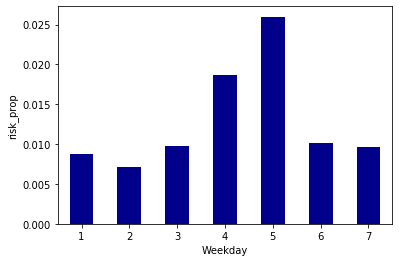

In [133]:
#two risk table variables

mapper2.plot.bar(color='darkblue')
plt.xticks(rotation=0)
plt.ylabel("risk_prop")  

Text(0, 0.5, 'risk_prop')

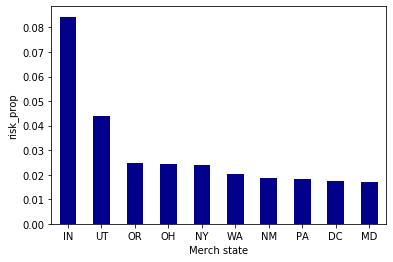

In [134]:
mapper.sort_values(ascending=False).head(10).plot.bar(color='darkblue')
plt.xticks(rotation=0)
plt.ylabel("risk_prop")  

In [71]:
print(traintest['state_risk'].min())
print(traintest['state_risk'].max())
print(traintest['state_risk'].mean())
print(traintest['state_risk'].std())

0.0
0.08438818565400844
0.010486297347627694
0.008824531244205068


In [72]:
print(traintest['Weekday_risk'].min())
print(traintest['Weekday_risk'].max())
print(traintest['Weekday_risk'].mean())
print(traintest['Weekday_risk'].std())

0.007127000817852553
0.025994362668336986
0.0104799333095153
0.004293480241494261


In [24]:
traintest_keep=traintest.drop(columns=['Weekday','Month','Recnum', 'Cardnum', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount','check_record','check_date'])

In [57]:
traintest_keep.to_csv('traintest.csv')
OOTvali.to_csv('ootdata.csv')

In [64]:
## becasue we create the variable that "over the past 30 days" so we should cut the variables that don't include the data over past 30 days.

traintest_keep2=traintest_keep[traintest_keep['Date']>pd.to_datetime('2010-01-15')]

In [5]:
traintest_keep=pd.read_csv("traintest.csv",index_col=0)
OOTvali=pd.read_csv("ootdata.csv",index_col=0)
traintest_keep.Date=pd.to_datetime(traintest_keep.Date)
OOTvali.Date=pd.to_datetime(OOTvali.Date)

In [6]:
traintest_keep2=traintest_keep[traintest_keep['Date']>pd.to_datetime('2010-01-15')]

### Filter


In [7]:
goods=traintest_keep2[traintest_keep2['Fraud']==0]
bads=traintest_keep2[traintest_keep2['Fraud']==1]

In [25]:
numbads=len(bads)
columns=numeric_variables+['Weekday_risk','state_risk','Fraud']

In [26]:
ksscore=[]
for col in columns:
    col_score=stats.ks_2samp(goods[col], bads[col])[0]
    ksscore.append(col_score)   

In [34]:
FDRATE=[]
topRows = int(round(len(traintest_keep2)*0.03))
for col in columns:
    temp=traintest_keep2.sort_values(col,ascending=False)
    ex_l=temp.head(topRows)
    ex_s=temp.tail(topRows)
    fdr1=sum(ex_l.Fraud)/numbads
    fdr2=sum(ex_s.Fraud)/numbads
    fdR=max(fdr1,fdr2)
    FDRATE.append(fdR)

In [35]:
d= {'col_name': columns, 'ks_score': ksscore,'fraud_rate':FDRATE}
KSFDR=pd.DataFrame(data=d)

In [36]:
KSFDR.sort_values(by='ks_score')

,col_name,ks_score,fraud_rate
263,Cardnum_number0/7,0.078556,0.071511
343,Merchnum_number0/30,0.105943,0.013841
347,card_state_actual/max_30,0.116539,0.038062
241,Merchnum_number1/30,0.122454,0.025375
38,Merchnum_number1/14,0.123388,0.026528
...,...,...,...
30,card_merch_total_3,0.676676,0.632065
245,card_zip_total_3,0.680122,0.643599
200,card_merch_total_7,0.681698,0.634371
147,card_zip_total_7,0.686317,0.641292


In [37]:
KSFDR.to_csv("KSFDR.csv")

In [38]:
KSFDR['ks_rank']=KSFDR['ks_score'].rank()
KSFDR['fraud_rate_rank']=KSFDR['fraud_rate'].rank()
KSFDR['average_rank']=(KSFDR['ks_rank']+KSFDR['fraud_rate_rank'])/2
KSFDR=KSFDR.sort_values(by=['average_rank'],ascending=False)

In [39]:
###remove about half the variables
KSFDR_keep=KSFDR[KSFDR['average_rank']>np.median(KSFDR.average_rank)]

In [43]:
traintest_keep_stepwise=traintest_keep2[KSFDR_keep.col_name.to_list()]

### Then use a wrapper method to reduce to about 30 to 40 variables. Using stepwise logistic regression.


In [1]:
model=LogisticRegression()
rfecv = RFECV(estimator=model, step=1, cv=2, verbose=0, n_jobs=-1, scoring='roc_auc')
rfecv.fit(traintest_keep_stepwise.drop(columns=['Fraud']), traintest_keep_stepwise.Fraud)

In [48]:
var_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv.ranking_),traintest_keep_stepwise.drop(columns=['Fraud']).columns)),
                            columns = ['ranking', 'variable']).reset_index()

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 8


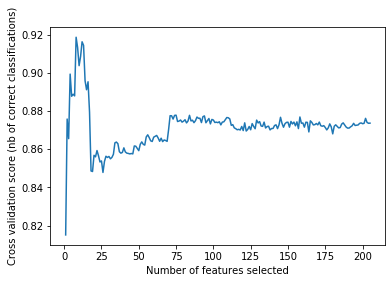

In [49]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1,len(rfecv.grid_scores_)+1),rfecv.grid_scores_)

In [50]:
var_30=var_selected[var_selected['index']<=29].variable.to_list()

In [54]:
var_30

['Cardnum_count_past_1',
 'Cardnum_total_14',
 'Cardnum_total_30',
 'card_merch_med_7',
 'card_state_count_past_3',
 'card_state_total_3',
 'card_zip_avg_7',
 'state_risk',
 'card_zip_med_14',
 'card_merch_avg_30',
 'card_merch_max_30',
 'card_zip_total_30',
 'card_state_med_0',
 'card_merch_max_7',
 'card_zip_max_1',
 'card_merch_total_7',
 'merch_state_total_1',
 'Merchnum_total_14',
 'merch_state_total_7',
 'card_zip_total_14',
 'Merchnum_med_3',
 'merch_zip_avg_1',
 'merch_zip_max_3',
 'card_merch_max_3',
 'merch_zip_actual/med_30',
 'Merchnum_actual/med_30',
 'card_merch_total_3',
 'card_merch_actual/total_3',
 'Cardnum_amt1/30',
 'card_zip_max_30']

In [53]:
train_test=traintest_keep_stepwise[var_30+['Fraud']]
train_test.to_csv("train_test.csv")